In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_20minutes.csv")
data.drop(['Month'], axis =1, inplace= True)
#data.set_index("time", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['Unnamed: 0',  'green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3*3:, -1])
n_p = n_p + 365*24*3*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 3 + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [6]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(78840, 235) 78840 (78840,)
(78840, 47, 5) (78840,) (19630, 47, 5) (19630,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 78840 samples, validate on 19630 samples
Epoch 1/100
 - 42s - loss: 0.0417 - val_loss: 0.0273
Epoch 2/100
 - 42s - loss: 0.0211 - val_loss: 0.0249
Epoch 3/100
 - 41s - loss: 0.0163 - val_loss: 0.0146
Epoch 4/100
 - 48s - loss: 0.0141 - val_loss: 0.0136
Epoch 5/100
 - 47s - loss: 0.0135 - val_loss: 0.0128
Epoch 6/100
 - 47s - loss: 0.0132 - val_loss: 0.0152
Epoch 7/100
 - 51s - loss: 0.0129 - val_loss: 0.0150
Epoch 8/100
 - 48s - loss: 0.0128 - val_loss: 0.0148
Epoch 9/100
 - 47s - loss: 0.0126 - val_loss: 0.0148
Epoch 10/100
 - 48s - loss: 0.0125 - val_loss: 0.0145
Epoch 11/100
 - 48s - loss: 0.0125 - val_loss: 0.0149
Epoch 12/100
 - 47s - loss: 0.0124 - val_loss: 0.0151
Epoch 13/100
 - 47s - loss: 0.0123 - val_loss: 0.0139
Epoch 14/100
 - 48s - loss: 0.0121 - val_loss: 0.0135
Epoch 15/100
 - 47s - loss: 0.0119 - val_loss: 0.0138
Epoch 16/100
 - 47s - loss: 0.0116 - val_loss: 0.0134
Epoch 17/100
 - 47s - loss: 0.0114 - val_loss: 0.0122
Epoch 18/100
 - 49s - loss: 0.0112 - val_

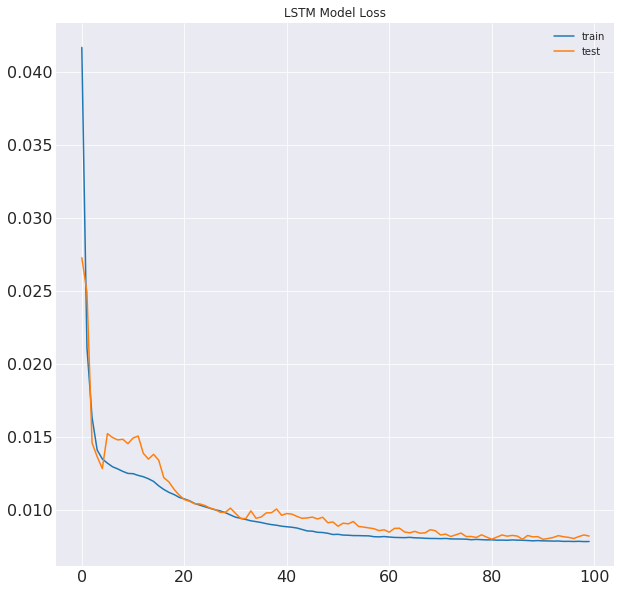

In [8]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [9]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9895857067421531
MAE:  156.60782
RMSE: 226.34788973502714
mean absolute error percentage:  3.960370272397995


In [10]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.987745374994145
MAE:  225.29074
RMSE: 317.1625421215437
mean absolute error percentage:  3.969293460249901


Set for same data size

In [6]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 3
train = values[n_train_hours - 26280 :n_train_hours, :]
test = values[n_train_hours:n_train_hours + 6469, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 235) 26280 (26280,)
(26280, 47, 5) (26280,) (6469, 47, 5) (6469,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6469 samples
Epoch 1/100
 - 11s - loss: 0.0492 - val_loss: 0.0351
Epoch 2/100
 - 9s - loss: 0.0275 - val_loss: 0.0278
Epoch 3/100
 - 9s - loss: 0.0216 - val_loss: 0.0218
Epoch 4/100
 - 9s - loss: 0.0183 - val_loss: 0.0211
Epoch 5/100
 - 9s - loss: 0.0168 - val_loss: 0.0194
Epoch 6/100
 - 9s - loss: 0.0155 - val_loss: 0.0206
Epoch 7/100
 - 9s - loss: 0.0145 - val_loss: 0.0175
Epoch 8/100
 - 9s - loss: 0.0137 - val_loss: 0.0148
Epoch 9/100
 - 9s - loss: 0.0135 - val_loss: 0.0149
Epoch 10/100
 - 9s - loss: 0.0129 - val_loss: 0.0123
Epoch 11/100
 - 9s - loss: 0.0124 - val_loss: 0.0122
Epoch 12/100
 - 9s - loss: 0.0122 - val_loss: 0.0131
Epoch 13/100
 - 9s - loss: 0.0128 - val_loss: 0.0195
Epoch 14/100
 - 9s - loss: 0.0123 - val_loss: 0.0127
Epoch 15/100
 - 9s - loss: 0.0122 - val_loss: 0.0118
Epoch 16/100
 - 9s - loss: 0.0120 - val_loss: 0.0122
Epoch 17/100
 - 9s - loss: 0.0121 - val_loss: 0.0144
Epoch 18/100
 - 9s - loss: 0.0125 - val_loss: 0.0168
Epoch

In [8]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9878477293698376
MAE:  189.76195
RMSE: 261.5968540760764
mean absolute error percentage:  5.53390271961689


In [9]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9880981457134723
MAE:  201.9533
RMSE: 276.5423933368987
mean absolute error percentage:  4.961295425891876
